In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import os
import sys
sys.path.insert(1, '../python-scripts-c6fxKDJrSsWp1xCxON1Y7g')
from api_calls import *

url = "https://nomad-hzb-ce.de/nomad-oasis/api/v1"
token = os.environ['NOMAD_CLIENT_ACCESS_TOKEN']

### EDAQ Analysis

**Insert the name of your data file here.** You can also adapt the other parameters.

In [23]:
upload_name = '250502_GZ_Cu_nanop_NO3RR_benchmark'

start_volume = 70
sample_area = 0.126

# GSE calibration curve parameters (recorded 25.04.2025)
slope = -55.109
intercept = 37.416

faradaic_constant = 96485.33
z = 8

R = 50
ref = 0.893

In [24]:
def get_derivative(x_col, fx_col):
    return np.gradient(fx_col, x_col)

In [25]:
all_data = []
for run_number in range(1, 7):
    gse_file_name = f'250502_GSE_CP{run_number}.txt'

    cp_data_list = get_specific_entrytype_of_uploads(url, token, [upload_name], 'CE_NOME_Chronopotentiometry', with_meta=False)
    cp_data = next((item for item in cp_data_list if item.get('data_file', '').endswith(f'#{run_number}.DTA')), None)
    cp_current = cp_data.get('properties').get('step_1_current')
    print(f'cp current run {run_number}: {cp_current} A')
    
    volume_cell = (start_volume - run_number) / 1000
    print(f'cell volume run {run_number}: {volume_cell}')

    data = pd.read_csv(gse_file_name, skiprows=4, sep=' ', header=None, names=['Time [s]', 'Potential [mV]', 'CP Potential [mV]'])
    data['Time [s]'] = pd.to_timedelta(data['Time [s]']).dt.total_seconds()
    
    data['CP Potential - iR [mV]'] = data['CP Potential [mV]'] * (-1) / 1000 - cp_current * R + ref
    
    #from GSE potential profile to NH3 concentration profile [uM]
    data['conc_NH3 [µM]'] = 10 ** ((data['Potential [mV]'] - intercept) / slope)
    # smooth conc data
    smoothed = lowess(endog=data['conc_NH3 [µM]'], exog=data['Time [s]'], frac=0.1)  # frac is used to tune the smoothing
    data['conc_NH3_smoothed'] = smoothed[:, 1]
    # first derivative NH3 concentration
    data['rate NH3 [µM/s]'] = get_derivative(data['Time [s]'], data['conc_NH3_smoothed'])
    data['rate NH3 [nmol/s*cm²]'] = data['rate NH3 [µM/s]'] * 1000 * volume_cell / sample_area
    # second derivative NH3 concentration
    data['conc_NH3_second_derivative'] = get_derivative(data['Time [s]'], data['rate NH3 [µM/s]'])
    
    data['FE [%]'] = data['rate NH3 [nmol/s*cm²]'] * sample_area * faradaic_constant * z * (10 ** -7) / np.abs(cp_current)

    all_data.append(data)

cp current run 1: -3.2e-05 A
cell volume run 1: 0.069
cp current run 2: -8e-05 A
cell volume run 2: 0.068
cp current run 3: -0.0002 A
cell volume run 3: 0.067
cp current run 4: -0.0005 A
cell volume run 4: 0.066
cp current run 5: -0.00125 A
cell volume run 5: 0.065
cp current run 6: -0.003125 A
cell volume run 6: 0.064


In [26]:
from IPython.display import display
for idx, data in enumerate(all_data):
    print(f'Run number {idx+1}:')
    display(data)

Run number 1:


,Time [s],Potential [mV],CP Potential [mV],CP Potential - iR [mV],conc_NH3 [µM],conc_NH3_smoothed,rate NH3 [µM/s],rate NH3 [nmol/s*cm²],conc_NH3_second_derivative,FE [%]
0,1.0,54.14,184.68,0.70992,0.497197,0.490034,0.001128,0.617902,-7.297308e-09,187.798105
1,2.0,54.14,184.68,0.70992,0.497197,0.491163,0.001128,0.617898,-1.173843e-08,187.796891
2,3.0,54.12,417.00,0.47760,0.497613,0.492291,0.001128,0.617889,-1.784997e-08,187.794198
3,4.0,54.12,417.00,0.47760,0.497613,0.493419,0.001128,0.617878,-2.224268e-08,187.790949
4,5.0,54.25,622.59,0.27201,0.494917,0.494548,0.001128,0.617864,-3.203602e-08,187.786794
...,...,...,...,...,...,...,...,...,...,...
610,611.0,45.96,385.66,0.50894,0.699780,0.699689,0.000004,0.002241,-3.077968e-08,0.681036
611,612.0,45.96,385.66,0.50894,0.699780,0.699693,0.000004,0.002228,-1.532978e-08,0.677284
612,613.0,45.95,504.38,0.39022,0.700073,0.699698,0.000004,0.002224,-2.886249e-09,0.675933
613,614.0,45.95,504.38,0.39022,0.700073,0.699702,0.000004,0.002225,2.745848e-09,0.676324


Run number 2:


,Time [s],Potential [mV],CP Potential [mV],CP Potential - iR [mV],conc_NH3 [µM],conc_NH3_smoothed,rate NH3 [µM/s],rate NH3 [nmol/s*cm²],conc_NH3_second_derivative,FE [%]
0,1.0,45.92,321.65,0.57535,0.700951,0.694449,0.000016,0.008633,3.924117e-08,1.049507
1,2.0,45.92,321.65,0.57535,0.700951,0.694465,0.000016,0.008654,5.946380e-08,1.052082
2,3.0,46.04,516.63,0.38037,0.697445,0.694481,0.000016,0.008697,8.089248e-08,1.057310
3,4.0,46.04,516.63,0.38037,0.697445,0.694498,0.000016,0.008741,8.329153e-08,1.062697
4,5.0,46.14,805.15,0.09185,0.694537,0.694514,0.000016,0.008787,8.559742e-08,1.068240
...,...,...,...,...,...,...,...,...,...,...
703,704.0,43.27,883.30,0.01370,0.783022,0.783139,0.000024,0.013190,-1.136911e-07,1.603533
704,705.0,43.28,883.31,0.01369,0.782695,0.783164,0.000024,0.013129,-1.100954e-07,1.596165
705,706.0,43.28,883.31,0.01369,0.782695,0.783188,0.000024,0.013071,-1.047049e-07,1.589086
706,707.0,43.26,883.30,0.01370,0.783350,0.783212,0.000024,0.013016,-7.523711e-08,1.582426


Run number 3:


,Time [s],Potential [mV],CP Potential [mV],CP Potential - iR [mV],conc_NH3 [µM],conc_NH3_smoothed,rate NH3 [µM/s],rate NH3 [nmol/s*cm²],conc_NH3_second_derivative,FE [%]
0,1.0,43.30,313.19,0.58981,0.782041,0.772658,0.000646,0.343589,6.302113e-07,16.708249
1,2.0,43.30,313.19,0.58981,0.782041,0.773304,0.000647,0.343924,9.625333e-07,16.724545
2,3.0,43.35,704.92,0.19808,0.780409,0.773952,0.000648,0.344613,1.330326e-06,16.758028
3,4.0,43.35,704.92,0.19808,0.780409,0.774601,0.000649,0.345339,1.402186e-06,16.793345
4,5.0,43.46,961.39,-0.05839,0.776831,0.775251,0.000651,0.346104,1.471742e-06,16.830544
...,...,...,...,...,...,...,...,...,...,...
655,656.0,21.66,993.87,-0.09087,1.931551,1.940053,0.000965,0.513207,-1.889556e-06,24.956528
656,657.0,21.66,993.87,-0.09087,1.931551,1.941017,0.000963,0.512216,-1.840124e-06,24.908328
657,658.0,21.66,993.87,-0.09087,1.931551,1.941980,0.000961,0.511250,-1.793716e-06,24.861364
658,659.0,21.67,993.86,-0.09086,1.930744,1.942940,0.000960,0.510308,-1.322953e-06,24.815564


Run number 4:


,Time [s],Potential [mV],CP Potential [mV],CP Potential - iR [mV],conc_NH3 [µM],conc_NH3_smoothed,rate NH3 [µM/s],rate NH3 [nmol/s*cm²],conc_NH3_second_derivative,FE [%]
0,1.0,22.11,251.94,0.66606,1.895573,1.830837,0.007147,3.743644,1.931473e-08,72.819272
1,2.0,22.12,247.97,0.67003,1.894781,1.837984,0.007147,3.743654,9.751930e-09,72.819468
2,3.0,22.12,247.97,0.67003,1.894781,1.845131,0.007147,3.743654,-4.102024e-08,72.819470
3,4.0,22.12,388.25,0.52975,1.894781,1.852278,0.007147,3.743611,-1.293111e-07,72.818632
4,5.0,22.12,388.25,0.52975,1.894781,1.859425,0.007147,3.743519,-2.333918e-07,72.816835
...,...,...,...,...,...,...,...,...,...,...
608,609.0,-4.34,648.14,0.26986,5.723984,5.727992,0.006416,3.360739,-1.676803e-06,65.371222
609,610.0,-4.40,594.67,0.32333,5.738351,5.734407,0.006414,3.359858,-1.687006e-06,65.354078
610,611.0,-4.40,594.67,0.32333,5.738351,5.740820,0.006413,3.358972,-1.696721e-06,65.336845
611,612.0,-4.44,551.42,0.36658,5.747950,5.747232,0.006411,3.358080,-1.276849e-06,65.319503


Run number 5:


,Time [s],Potential [mV],CP Potential [mV],CP Potential - iR [mV],conc_NH3 [µM],conc_NH3_smoothed,rate NH3 [µM/s],rate NH3 [nmol/s*cm²],conc_NH3_second_derivative,FE [%]
0,1.0,-3.92,370.96,0.58454,5.624412,5.626456,0.016343,8.430963,-3.478756e-06,65.597754
1,2.0,-3.92,548.21,0.40729,5.624412,5.642799,0.016340,8.429168,-5.282159e-06,65.583791
2,3.0,-3.92,548.21,0.40729,5.624412,5.659135,0.016333,8.425513,-7.188149e-06,65.555351
3,4.0,-3.78,1619.08,-0.66358,5.591608,5.675464,0.016325,8.421752,-7.359287e-06,65.526087
4,5.0,-3.78,1619.08,-0.66358,5.591608,5.691786,0.016318,8.417920,-7.476942e-06,65.496273
...,...,...,...,...,...,...,...,...,...,...
693,694.0,-18.64,1660.37,-0.70487,10.403611,10.403385,-0.000860,-0.443503,-5.634710e-07,-3.450707
694,695.0,-18.64,1660.37,-0.70487,10.403611,10.402525,-0.000860,-0.443764,-4.560804e-07,-3.452740
695,696.0,-18.65,1660.37,-0.70487,10.407959,10.401665,-0.000861,-0.443973,-3.718894e-07,-3.454368
696,697.0,-18.65,1660.37,-0.70487,10.407959,10.400804,-0.000861,-0.444148,-2.482299e-07,-3.455726


Run number 6:


,Time [s],Potential [mV],CP Potential [mV],CP Potential - iR [mV],conc_NH3 [µM],conc_NH3_smoothed,rate NH3 [µM/s],rate NH3 [nmol/s*cm²],conc_NH3_second_derivative,FE [%]
0,1.0,-18.14,388.79,0.66046,10.188522,10.170562,0.019849,10.082037,-4.259874e-06,31.377625
1,2.0,-18.18,388.79,0.66046,10.205565,10.190411,0.019845,10.079873,-6.805861e-06,31.370891
2,3.0,-18.18,386.27,0.66298,10.205565,10.210252,0.019835,10.075123,-1.013067e-05,31.356107
3,4.0,-18.20,386.27,0.66298,10.214096,10.230082,0.019824,10.069581,-1.146543e-05,31.338862
4,5.0,-18.20,982.56,0.06669,10.214096,10.249901,0.019812,10.063475,-1.234905e-05,31.319858
...,...,...,...,...,...,...,...,...,...,...
601,602.0,-28.30,1874.92,-0.82567,15.576615,15.571842,0.007919,4.022423,-6.482631e-07,12.518708
602,603.0,-28.30,1871.53,-0.82228,15.576615,15.579760,0.007919,4.022143,-4.671303e-07,12.517837
603,604.0,-28.33,1871.53,-0.82228,15.596153,15.587679,0.007918,4.021948,-3.218687e-07,12.517231
604,605.0,-28.33,1765.05,-0.71580,15.596153,15.595597,0.007918,4.021816,-1.852005e-07,12.516819


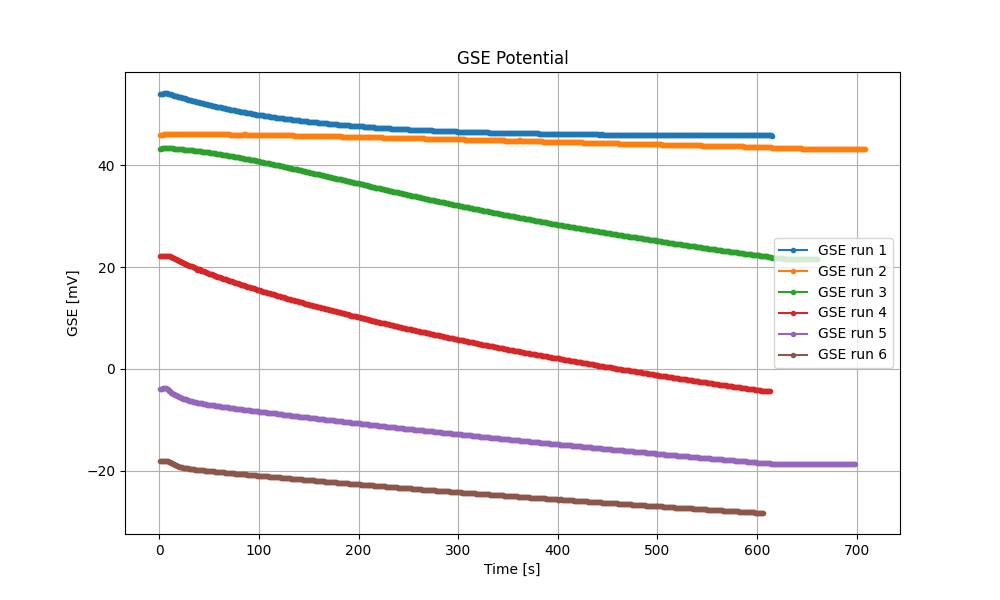

In [27]:
# make plot
plt.figure(figsize=(10, 6))
for idx, data in enumerate(all_data):
    plt.plot(data['Time [s]'], data['Potential [mV]'], label=f'GSE run {idx+1}', marker='.')

# label axis
plt.xlabel('Time [s]')
plt.ylabel('GSE [mV]')

plt.title('GSE Potential')
plt.legend()

# show plot
plt.grid(True)
plt.show()

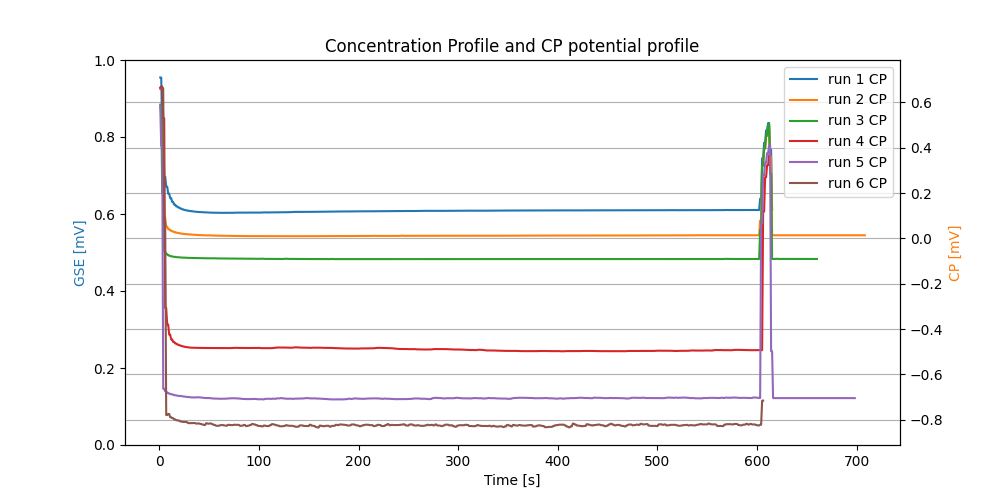

In [28]:
# make plot
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
for idx, data in enumerate(all_data):
    #ax1.plot(data['Time [s]'], data['Potential [mV]'], label=f'run {idx+1} GSE', marker=None)
    ax2.plot(data['Time [s]'], data['CP Potential - iR [mV]'], label=f'run {idx+1} CP', marker=None)
    
    # label axis
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('GSE [mV]', color='tab:blue')
    ax2.set_ylabel('CP [mV]', color='tab:orange')
    
    plt.title('Concentration Profile and CP potential profile')
    
    # legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    all_handles = handles1 + handles2
    all_labels = labels1 + labels2
    ax2.legend(all_handles, all_labels) #, loc="upper left")
    
# show plot
plt.grid(True)
plt.show()

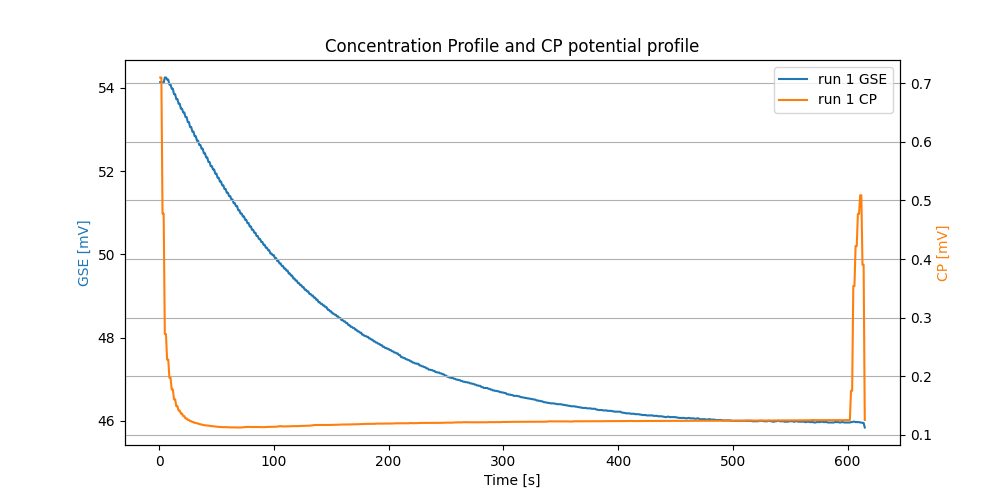

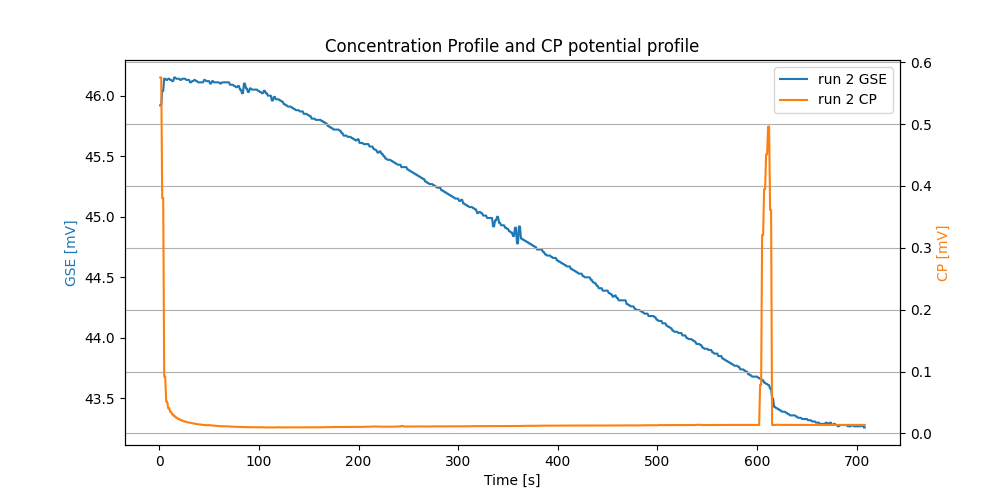

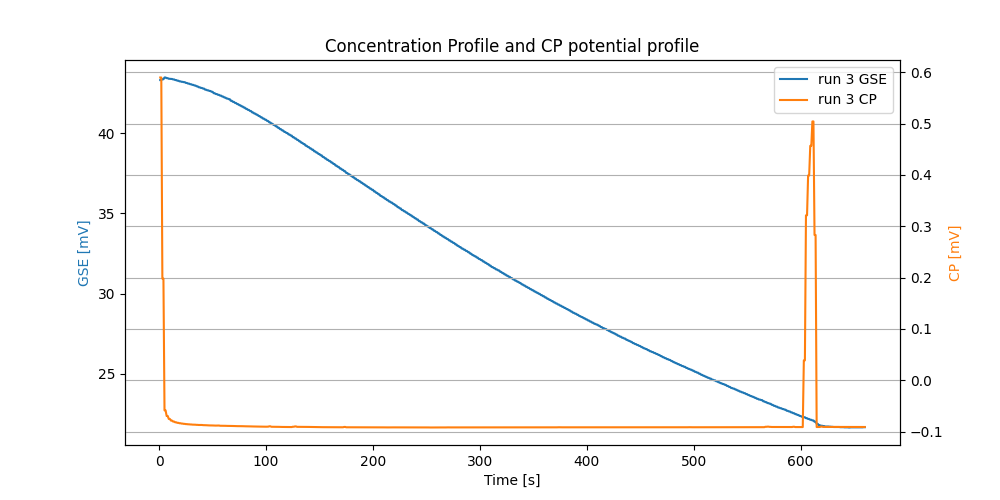

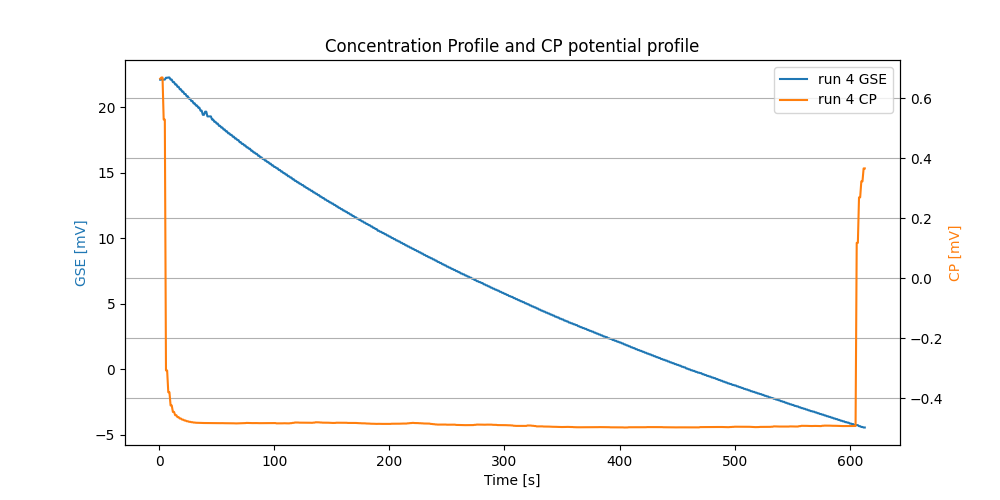

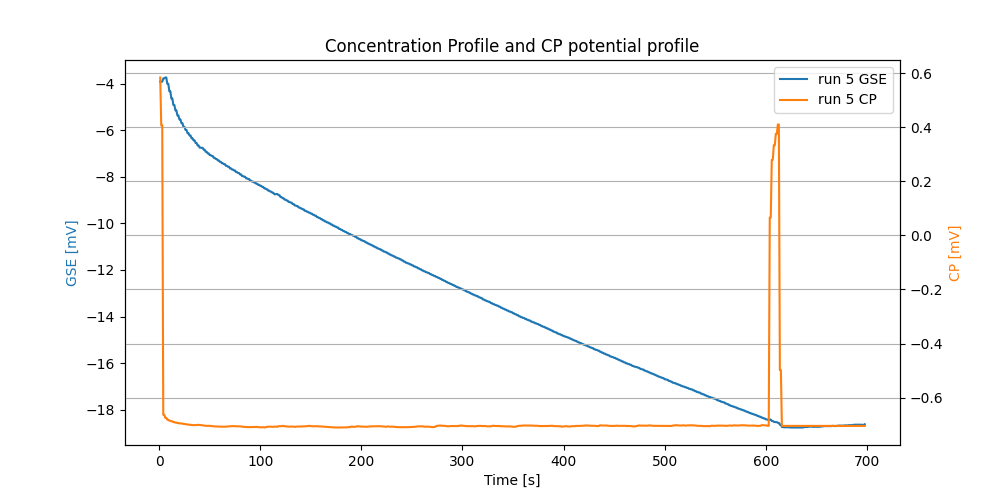

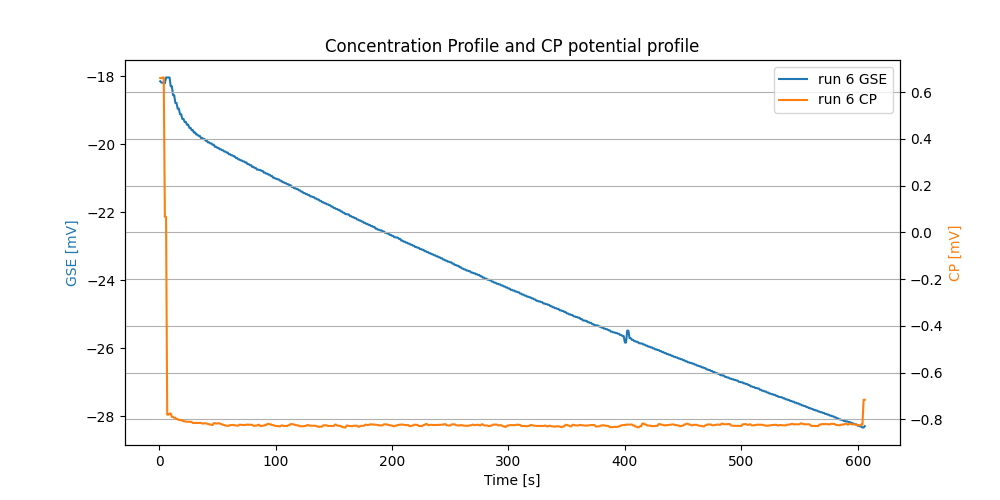

In [29]:
for idx, data in enumerate(all_data):
    # make plot
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    ax1.plot(data['Time [s]'], data['Potential [mV]'], label=f'run {idx+1} GSE', marker=None, color='tab:blue')
    ax2.plot(data['Time [s]'], data['CP Potential - iR [mV]'], label=f'run {idx+1} CP', marker=None, color='tab:orange')
    
    # label axis
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('GSE [mV]', color='tab:blue')
    ax2.set_ylabel('CP [mV]', color='tab:orange')
    
    plt.title('Concentration Profile and CP potential profile')
    
    # legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    all_handles = handles1 + handles2
    all_labels = labels1 + labels2
    ax2.legend(all_handles, all_labels) #, loc="upper left")
    
    # show plot
    plt.grid(True)
    plt.show()

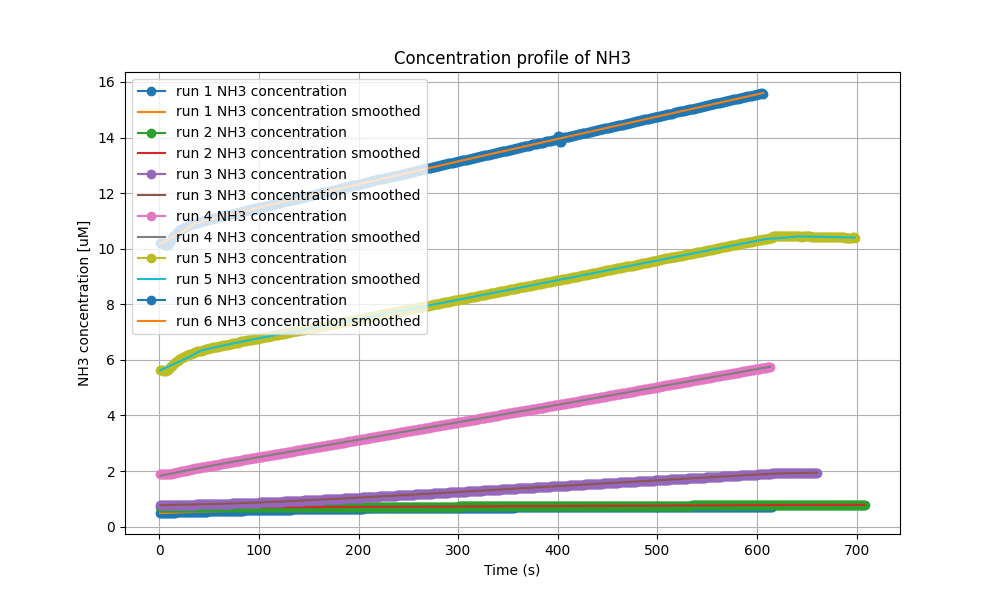

In [30]:
# make plot
plt.figure(figsize=(10, 6))
for idx, data in enumerate(all_data):
    plt.plot(data['Time [s]'], data['conc_NH3 [µM]'], label=f'run {idx+1} NH3 concentration', marker='o')
    plt.plot(data['Time [s]'], data['conc_NH3_smoothed'], label=f'run {idx+1} NH3 concentration smoothed')

# label axis
plt.xlabel('Time (s)')
plt.ylabel('NH3 concentration [uM]')

plt.title('Concentration profile of NH3')
plt.legend()

# show plot
plt.grid(True)
plt.show()

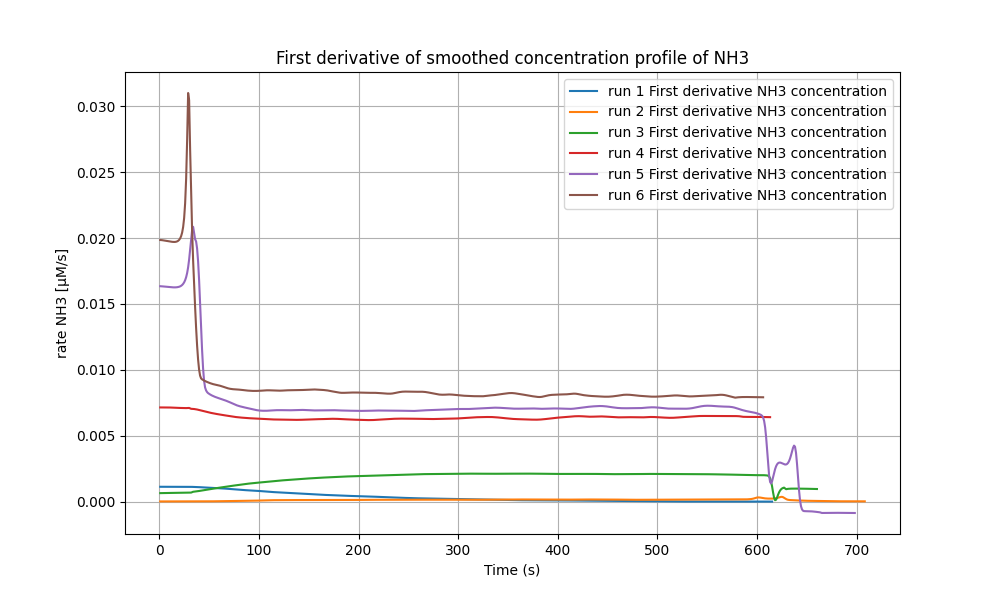

In [31]:
# make plot
plt.figure(figsize=(10, 6))
for idx, data in enumerate(all_data):
    plt.plot(data['Time [s]'], data['rate NH3 [µM/s]'], label=f'run {idx+1} First derivative NH3 concentration')

# label axis
plt.xlabel('Time (s)')
plt.ylabel('rate NH3 [µM/s]')

plt.title('First derivative of smoothed concentration profile of NH3')
plt.legend()

# show plot
plt.grid(True)
plt.show()

In [32]:
for idx, data in enumerate(all_data):
    # extrema: change of sign of the derivative
    signs = np.sign(data['conc_NH3_second_derivative'])
    sign_change = np.diff(signs)
    
    max_indices = np.where(sign_change == -2)[0] + 1  # derivative changes from + to -
    min_indices = np.where(sign_change == 2)[0] + 1   # derivative changes from - to +
    
    data['extremum'] = None
    data.loc[max_indices, 'extremum'] = 'max'
    data.loc[min_indices, 'extremum'] = 'min'
    
    
    peaks = pd.DataFrame()
    peaks = data.loc[data['extremum'].notna(), ['Time [s]', 'Potential [mV]', 'conc_NH3_smoothed', 'rate NH3 [µM/s]', 'rate NH3 [nmol/s*cm²]', 'FE [%]', 'extremum', 'conc_NH3_second_derivative']]
    
    print(f'Run {idx+1} peak overview:')
    display(peaks)
    print('\n')

Run 1 peak overview:


,Time [s],Potential [mV],conc_NH3_smoothed,rate NH3 [µM/s],rate NH3 [nmol/s*cm²],FE [%],extremum,conc_NH3_second_derivative
20,21.0,53.41,0.512589,0.001127,0.617133,187.564345,min,2.839086e-09
29,30.0,52.95,0.522734,0.001128,0.617602,187.707073,max,-1.099579e-06
383,384.0,46.26,0.690864,0.000098,0.053510,16.263144,min,3.465117e-08
387,388.0,46.25,0.691256,0.000098,0.053618,16.296025,max,-2.915970e-09
532,533.0,45.99,0.698867,0.000010,0.005239,1.592244,min,6.053641e-09
550,551.0,45.99,0.699090,0.000016,0.008873,2.696854,max,-3.379159e-09
555,556.0,45.99,0.699170,0.000016,0.008711,2.647601,min,1.443449e-08
563,564.0,45.97,0.699300,0.000017,0.009097,2.764975,max,-7.817586e-08
586,587.0,45.96,0.699578,0.000003,0.001862,0.565819,min,4.867824e-07
595,596.0,45.97,0.699620,0.000005,0.002781,0.845368,max,-6.114013e-09




Run 2 peak overview:


,Time [s],Potential [mV],conc_NH3_smoothed,rate NH3 [µM/s],rate NH3 [nmol/s*cm²],FE [%],extremum,conc_NH3_second_derivative
16,17.0,46.14,0.694715,0.000017,0.009198,1.118261,max,-5.601263e-10
30,31.0,46.11,0.694949,0.000016,0.008786,1.068174,min,2.073766e-09
132,133.0,45.90,0.701398,0.000122,0.065677,7.984463,max,-4.329778e-08
142,143.0,45.87,0.702605,0.000120,0.064716,7.867654,min,3.660666e-08
147,148.0,45.85,0.703206,0.000120,0.064854,7.884407,max,-3.233859e-08
150,151.0,45.83,0.703566,0.000120,0.064802,7.878019,min,3.943848e-08
173,174.0,45.73,0.706425,0.000127,0.068547,8.333313,max,-1.812757e-08
192,193.0,45.65,0.708818,0.000125,0.067356,8.188515,min,7.924717e-08
236,237.0,45.44,0.714925,0.000148,0.080012,9.727175,max,-1.605115e-08
254,255.0,45.36,0.717557,0.000144,0.077769,9.454501,min,1.936481e-09




Run 3 peak overview:


,Time [s],Potential [mV],conc_NH3_smoothed,rate NH3 [µM/s],rate NH3 [nmol/s*cm²],FE [%],extremum,conc_NH3_second_derivative
314,315.0,31.50,1.278966,0.002124,1.129174,54.910156,max,-4.313601e-08
333,334.0,30.80,1.319229,0.002114,1.123992,54.658184,min,6.343052e-08
348,349.0,30.20,1.351006,0.002122,1.128562,54.880384,max,-2.602112e-08
358,359.0,29.83,1.372221,0.002121,1.127689,54.837945,min,3.983894e-08
372,373.0,29.31,1.401939,0.002124,1.129682,54.934871,max,-1.062644e-08
412,413.0,27.91,1.486312,0.002098,1.115786,54.259111,min,1.765268e-08
433,434.0,27.24,1.530456,0.002106,1.119705,54.449701,max,-1.940436e-07
456,457.0,26.47,1.578632,0.002086,1.109092,53.933592,min,6.346367e-08
460,461.0,26.35,1.586976,0.002086,1.109365,53.946878,max,-2.082836e-08
473,474.0,25.97,1.614067,0.002082,1.106855,53.824815,min,9.733902e-09




Run 4 peak overview:


,Time [s],Potential [mV],conc_NH3_smoothed,rate NH3 [µM/s],rate NH3 [nmol/s*cm²],FE [%],extremum,conc_NH3_second_derivative
2,3.0,22.12,1.845131,0.007147,3.743654,72.819470,max,-4.102024e-08
26,27.0,20.66,2.016146,0.007097,3.717666,72.313965,min,9.681247e-07
29,30.0,20.30,2.037449,0.007108,3.723307,72.423701,max,-1.199156e-05
137,138.0,13.30,2.736831,0.006205,3.250064,63.218442,min,6.839518e-08
173,174.0,11.40,2.961766,0.006286,3.292868,64.051042,max,-9.437408e-08
210,211.0,9.66,3.192342,0.006186,3.240485,63.032110,min,1.733791e-07
243,244.0,8.12,3.398548,0.006298,3.298908,64.168529,max,-2.872002e-07
272,273.0,6.91,3.580761,0.006266,3.282081,63.841211,min,3.408875e-07
330,331.0,4.56,3.948307,0.006422,3.363965,65.433975,max,-8.143801e-09
377,378.0,2.80,4.244452,0.006217,3.256754,63.348561,min,3.647160e-07




Run 5 peak overview:


,Time [s],Potential [mV],conc_NH3_smoothed,rate NH3 [µM/s],rate NH3 [nmol/s*cm²],FE [%],extremum,conc_NH3_second_derivative
15,16.0,-5.15,5.870860,0.016256,8.385815,65.246478,min,2.147272e-06
33,34.0,-6.44,6.183801,0.020853,10.757365,83.698506,max,-1.033448e-04
105,106.0,-8.54,6.819210,0.006893,3.555817,27.666305,min,1.944061e-07
120,121.0,-8.87,6.923002,0.006942,3.581320,27.864739,max,-2.708125e-07
129,130.0,-9.11,6.985428,0.006931,3.575343,27.818229,min,1.697015e-07
141,142.0,-9.40,7.068792,0.006962,3.591657,27.945167,max,-6.195913e-07
154,155.0,-9.67,7.158990,0.006919,3.569325,27.771408,min,1.563802e-07
171,172.0,-10.10,7.276783,0.006938,3.579243,27.848577,max,-1.178222e-07
201,202.0,-10.76,7.484051,0.006885,3.551564,27.633215,min,2.672935e-07
219,220.0,-11.16,7.608192,0.006913,3.566163,27.746809,max,-9.838458e-08




Run 6 peak overview:


,Time [s],Potential [mV],conc_NH3_smoothed,rate NH3 [µM/s],rate NH3 [nmol/s*cm²],FE [%],extremum,conc_NH3_second_derivative
14,15.0,-18.78,10.447385,0.019701,10.006678,31.143090,min,9.909007e-07
29,30.0,-19.65,10.780926,0.030455,15.469258,48.143902,max,-2.144529e-03
95,96.0,-20.93,11.445002,0.008399,4.266339,13.277833,min,4.263243e-07
109,110.0,-21.17,11.562920,0.008447,4.290746,13.353793,max,-1.214255e-06
120,121.0,-21.35,11.655654,0.008419,4.276449,13.309297,min,5.538312e-07
135,136.0,-21.62,11.782292,0.008455,4.294774,13.366329,max,-3.736005e-07
137,138.0,-21.66,11.799201,0.008455,4.294425,13.365242,min,1.096697e-07
154,155.0,-21.93,11.943387,0.008512,4.323355,13.455278,max,-1.401794e-06
184,185.0,-22.43,12.195330,0.008253,4.192252,13.047256,min,1.498107e-06
196,197.0,-22.62,12.294572,0.008279,4.205300,13.087863,max,-6.203328e-07


### Old calculations to find point where curve flattens

In [12]:
# this is the size of a sliding window to calculate a moving average (-> smooth data because we have a lot of double values)
# at the moment set to 60s but can be changed
window_size = 60

# since some curves are also flat in the beginning you can set this number
# derivatives are only checked after this starting time (in s)
starting_time = 0

# this is the threshold of the derivative
# as soon as the derivative gets smaller than this threshold the time is used as the result
threshold = 0.0001


# old calculations:
data['Smoothed_Voltage'] = data['Potential [mV]'].rolling(window=window_size).mean()
# calculate derivatives
data['Voltage_Diff'] = np.gradient(data['Potential [mV]'], data['Time [s]'])
data['Smoothed_Voltage_Diff'] = np.gradient(data['Smoothed_Voltage'], data['Time [s]'])
# find time < threshold
threshold_data = data[starting_time:]
flatten_point_tmp =  threshold_data.loc[abs(threshold_data['Smoothed_Voltage_Diff']) < threshold]
if len(flatten_point_tmp) > 0:
    flatten_point = flatten_point_tmp.iloc[0]
else:
    print("Gradient did not vanish, choosing last point")
    flatten_point = threshold_data.iloc[-1]

Gradient did not vanish, choosing last point
